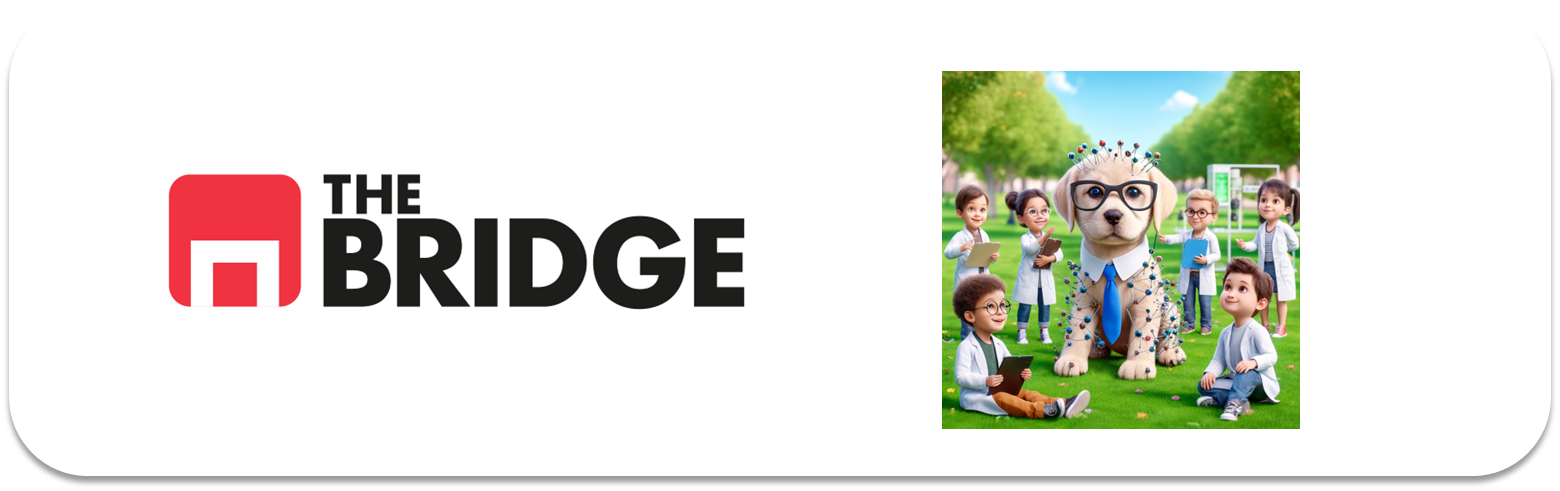

### CAPAS DE PREPROCESADO DE KERAS

Igual que sklearn tenemos sus "transformers" y difernentes funciones para poder procesar los datos, para luego, si queremos incluirlos en un pipeline, en Keras existen "capas" de preprocesamiento que podemos incluir en el modelo de forma análoga

### El problema y el dataset

En este caso nuestro problema será clasificar una serie de fármacos a partir de features numéricas y features de texto, que tendremos que convertir para poder utilizar.

Vamos a trabajar con un dataset que hemos empleado antes con reviews de medicinas, pero en el que no utilizamos los campos de texto. Sobre él vamos a hacer el preprocesado usando esas capas equivalentes a lo que ya hemos empleado con sklearn. Eso nos permitirá introducir las capas de Embedding y de ahí a revisar un ejemplo de clasificación con texto en lenguaje natural que ahora haremos con modelos DL. 

Primero, las importaciones y cargar el dataset, y echar un "vistazo":

In [1]:
import numpy as np
import pandas as pd
import random as rm
import re
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("./data/pharma_full.csv")
df.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,Sales,Production
0,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",318440,398.0
1,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",888949,909.0
2,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,264077,465.0
3,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,542110,602.0
4,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,83761,124.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   urlDrugName        3107 non-null   object 
 1   rating             3107 non-null   int64  
 2   effectiveness      3107 non-null   object 
 3   sideEffects        3107 non-null   object 
 4   condition          3106 non-null   object 
 5   benefitsReview     3107 non-null   object 
 6   sideEffectsReview  3105 non-null   object 
 7   commentsReview     3099 non-null   object 
 8   Sales              3107 non-null   int64  
 9   Production         3107 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 242.9+ KB


Las prepararemos un poco para que podamos emplear todos los tipos de capas

Los missings seguiremos tratándolos, por ahora, a parte

In [7]:
df_clean = df.fillna("No Value")

In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   urlDrugName        3107 non-null   object 
 1   rating             3107 non-null   int64  
 2   effectiveness      3107 non-null   object 
 3   sideEffects        3107 non-null   object 
 4   condition          3107 non-null   object 
 5   benefitsReview     3107 non-null   object 
 6   sideEffectsReview  3107 non-null   object 
 7   commentsReview     3107 non-null   object 
 8   Sales              3107 non-null   int64  
 9   Production         3107 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 242.9+ KB


Claramente el target es "rating"

In [9]:
target = "rating"

### Split train/test

In [10]:
train_set, test_set  = train_test_split(df_clean, test_size= 0.2, random_state= 42)

In [8]:
train_set.shape

(2485, 10)

In [9]:
test_set.shape

(622, 10)

### MiniEda

Del miniEDA sólo vamos a hacer el análisis del target, nos vamos a quedar y a tratar todas las variables como features.

In [10]:
train_set[target].value_counts()

10    591
8     464
9     370
7     267
1     243
5     132
3     123
6     119
4      89
2      87
Name: rating, dtype: int64

Es un dataset desbalanceado en el target. Luego veremos como equilibrarlo dentro de lo posible sin aplicar SMOTE ni undersampling (con campos con texto además tiene aún menos utilidad, en general)

Como ya sabrás a keras le gusta que las clases empiecen en cero así que lo tratamos rápido:

In [11]:
train_set[target] = train_set[target]-1
test_set[target] = test_set[target] - 1

### Tratamiento de Features

Vamos a hacer lo siguiente:  
1- Crear features nuevas (conteos de palabras por campo de texto libre)  
2- Escalado de las features numéricas  
3- Conversión de las categóricas  
4- Vectorización de las features de texto  

#### #1 Creación de features nuevas

Existen varios campos con texto libre y en breve los vectorizaremos pero antes puede ser interesante crear una serie de features nuevas que cuenten el número aproximado de palabras que hay en cada uno de esos campos. Estos campos son básicamente lo que tienen en su nombre la palabra "Review"

In [12]:
for col in [col for col in train_set.columns if "Review" in col]:
    train_set[col + "_wc"] = train_set[col].apply(lambda value: len(value.split()))
    test_set[col + "_wc"] = test_set[col].apply(lambda value: len(value.split()))


In [11]:
train_set

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,Sales,Production,benefitsReview_wc,sideEffectsReview_wc,commentsReview_wc
2686,zoloft,9,Highly Effective,No Side Effects,anxiety,becoming a normal functioning individual. it h...,I had no real side effects unless you consider...,taken once daily.,135166,335.0,62,15,3
1192,adipex-p,9,Highly Effective,Mild Side Effects,to lose 30 pounds,When BMI rating is over 27 its time to get tha...,jittery.. sometimes euphoric.. tired but cant ...,last results 3 months on adipex-p lost 30 poun...,739564,939.0,163,10,248
2738,tri-luma,7,Moderately Effective,Severe Side Effects,hyperpigmentation,lightening of acne scars,"redness, dryness, breakdown of skin",this topical compound was used to reduce hyper...,683247,843.0,4,5,42
2780,yasmin,2,Highly Effective,Moderate Side Effects,birth control,There was no chance of pregancy because i lost...,no libido what so ever. My breasts hurt like n...,I was given this to prevent pregnancy and i am...,222295,282.0,22,50,27
1735,requip,7,Considerably Effective,No Side Effects,restless leg syndrome,I took this medication to treat restless leg s...,"I did need to take more as time went on, and I...",I took one milligram at night to treat the sym...,344748,505.0,93,69,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,zyrtec,9,Highly Effective,Mild Side Effects,atopic eczema,The drug was very effective in counteracting s...,I felt slightly tired after taking Zyrtec. How...,This is a non-prescription drug and I took it ...,156028,356.0,74,54,51
1095,neurontin,0,Ineffective,Severe Side Effects,all over and various type pain,None,"Nausea, extreme sleepiness,severe headache, ji...",Day one I felt negative side effects after tak...,317886,337.0,1,10,120
1130,wellbutrin,6,Moderately Effective,Mild Side Effects,depression,"I experienced less depression, increased libid...",I have a dry mouth and eyes. Drug has decrease...,"Prescribed at 300 mg per day, have taken as mu...",556187,696.0,15,15,24
1294,wellbutrin,2,Considerably Effective,Moderate Side Effects,stop smoking,"The treatment was effective in reducing my ""ap...","After a while, I began to notice that NOTHING ...",I was taking the Bupropion as an aide to break...,728338,789.0,44,105,92


***

#### Escalado/Normalización

Lo primero es quedarnos con las columnas numéricas

In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2485 entries, 2686 to 860
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   urlDrugName           2485 non-null   object 
 1   rating                2485 non-null   int64  
 2   effectiveness         2485 non-null   object 
 3   sideEffects           2485 non-null   object 
 4   condition             2485 non-null   object 
 5   benefitsReview        2485 non-null   object 
 6   sideEffectsReview     2485 non-null   object 
 7   commentsReview        2485 non-null   object 
 8   Sales                 2485 non-null   int64  
 9   Production            2485 non-null   float64
 10  benefitsReview_wc     2485 non-null   int64  
 11  sideEffectsReview_wc  2485 non-null   int64  
 12  commentsReview_wc     2485 non-null   int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 271.8+ KB


Son claramente las que no son tipo `object`

In [14]:
numericas = [col for col in train_set.columns if train_set[col].dtype != "object" and col != target]
numericas

['Sales',
 'Production',
 'benefitsReview_wc',
 'sideEffectsReview_wc',
 'commentsReview_wc']

Y ahora las vamos a normalizar usando keras, y además vamos a entrenar un modelo baseline solo con estas features la numéricas.

### Normalization Layer

In [15]:
X_num = train_set[numericas].copy()
y_num = train_set[target]

Probemos primero sin normalizar, creando un diccionario para compensar las clases:


In [37]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])
earlyS = tf.keras.callbacks.EarlyStopping(patience = 30, restore_best_weights= True, monitor = "val_acc")
model.compile(loss="sparse_categorical_crossentropy", \
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),\
              metrics =["acc"])


In [38]:
history = model.fit(X_num, y_num, validation_split= 0.2, epochs=300, callbacks= earlyS)

Epoch 1/300


63/63 [==============================] - 2s 6ms/step - loss: 3730634240.0000 - acc: 0.2238 - val_loss: 2.2784 - val_acc: 0.2233
Epoch 2/300
63/63 [==============================] - 0s 4ms/step - loss: 2.2631 - acc: 0.2420 - val_loss: 2.2558 - val_acc: 0.2233
Epoch 3/300
63/63 [==============================] - 0s 4ms/step - loss: 2.2407 - acc: 0.2420 - val_loss: 2.2359 - val_acc: 0.2233
Epoch 4/300
63/63 [==============================] - 0s 4ms/step - loss: 2.2208 - acc: 0.2420 - val_loss: 2.2192 - val_acc: 0.2233
Epoch 5/300
63/63 [==============================] - 0s 4ms/step - loss: 2.2042 - acc: 0.2420 - val_loss: 2.2043 - val_acc: 0.2233
Epoch 6/300
63/63 [==============================] - 0s 3ms/step - loss: 2.1893 - acc: 0.2420 - val_loss: 2.1916 - val_acc: 0.2233
Epoch 7/300
63/63 [==============================] - 0s 3ms/step - loss: 2.1765 - acc: 0.2420 - val_loss: 2.1806 - val_acc: 0.2233
Epoch 8/300
63/63 [==============================] - 0s 3ms/step - loss: 2.1655 - acc:

In [23]:
model.evaluate(test_set[numericas], test_set[target])

 1/20 [>.............................] - ETA: 0s - loss: 2.2413 - acc: 0.3438

20/20 [==============================] - 0s 4ms/step - loss: 2.2577 - acc: 0.2428


[2.257659912109375, 0.24276527762413025]

La cosa está fácil... Vamos con la normalización

In [39]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
norm_layer = tf.keras.layers.Normalization() # Realmente hace una estandardization
 # Necestiamos hacer un "fit" previo como con el StandardScaler
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])
model.compile(loss="sparse_categorical_crossentropy", \
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),\
              metrics =["acc"])
norm_layer.adapt(X_num.to_numpy()) 
history = model.fit(X_num, y_num, validation_split = 0.2, epochs=300, callbacks= earlyS)

Epoch 1/300
63/63 [==============================] - 1s 7ms/step - loss: 2.2664 - acc: 0.1373 - val_loss: 2.2312 - val_acc: 0.1690
Epoch 2/300
63/63 [==============================] - 0s 5ms/step - loss: 2.1924 - acc: 0.2248 - val_loss: 2.1742 - val_acc: 0.2374
Epoch 3/300
63/63 [==============================] - 0s 4ms/step - loss: 2.1422 - acc: 0.2550 - val_loss: 2.1338 - val_acc: 0.2435
Epoch 4/300
63/63 [==============================] - 0s 4ms/step - loss: 2.1064 - acc: 0.2601 - val_loss: 2.1062 - val_acc: 0.2495
Epoch 5/300
63/63 [==============================] - 0s 4ms/step - loss: 2.0817 - acc: 0.2591 - val_loss: 2.0848 - val_acc: 0.2495
Epoch 6/300
63/63 [==============================] - 0s 4ms/step - loss: 2.0624 - acc: 0.2626 - val_loss: 2.0686 - val_acc: 0.2535
Epoch 7/300
63/63 [==============================] - 0s 4ms/step - loss: 2.0475 - acc: 0.2666 - val_loss: 2.0562 - val_acc: 0.2596
Epoch 8/300
63/63 [==============================] - 0s 4ms/step - loss: 2.0355 - a

In [40]:
model.evaluate(test_set[numericas], test_set[target])

 1/20 [>.............................] - ETA: 0s - loss: 0.6666 - acc: 0.8750

20/20 [==============================] - 0s 3ms/step - loss: 0.8317 - acc: 0.7540


[0.8316847681999207, 0.7540193200111389]

In [41]:
y_pred  = [np.argmax(pred) for pred in model.predict(test_set[numericas])]# hay que hacer un argmax pq tenemos un vbector de 10 valores

20/20 [==============================] - 0s 2ms/step


In [42]:
from sklearn.metrics import classification_report

In [43]:
print(classification_report(test_set[target], y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87        62
           1       0.00      0.00      0.00        16
           2       0.63      0.74      0.68        23
           3       0.75      0.17      0.27        18
           4       0.63      0.63      0.63        27
           5       0.00      0.00      0.00        38
           6       0.39      0.34      0.36        83
           7       0.59      0.98      0.74        94
           8       0.99      0.90      0.94       110
           9       0.97      1.00      0.99       151

    accuracy                           0.75       622
   macro avg       0.57      0.58      0.55       622
weighted avg       0.70      0.75      0.71       622



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Bien, pues ya tenemos baseline y una forma sencilla de incorporar la normalización a nuestro modelo, vamos con el resto de transformaciones, pero ya en la siguiente sesión. 

***

### Transformación de variables categóricas

Vamos a transformar las categóricas y lo vamos a hacer con un "ordinal encoder" por un lado y con un "onehot" por otro, eso sí, usando las capas de Keras,y cuáles son categóricas:

In [44]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2485 entries, 2686 to 860
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   urlDrugName           2485 non-null   object 
 1   rating                2485 non-null   int64  
 2   effectiveness         2485 non-null   object 
 3   sideEffects           2485 non-null   object 
 4   condition             2485 non-null   object 
 5   benefitsReview        2485 non-null   object 
 6   sideEffectsReview     2485 non-null   object 
 7   commentsReview        2485 non-null   object 
 8   Sales                 2485 non-null   int64  
 9   Production            2485 non-null   float64
 10  benefitsReview_wc     2485 non-null   int64  
 11  sideEffectsReview_wc  2485 non-null   int64  
 12  commentsReview_wc     2485 non-null   int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 271.8+ KB


Tiene pinta de que todas las que son objetc que no son Review

In [20]:
categoricals = [col for col in train_set.columns if "Review" not in col and train_set[col].dtype == "object"]
categoricals

['urlDrugName', 'effectiveness', 'sideEffects', 'condition']

Hagamos un check de cardinalidad:

In [30]:
for col in categoricals:
    print(f"Para <{col}>: {train_set[col].nunique()}")

Para <urlDrugName>: 463
Para <effectiveness>: 5
Para <sideEffects>: 5
Para <condition>: 1203


In [31]:
train_set.condition.value_counts()

depression                        182
acne                              135
anxiety                            51
insomnia                           41
birth control                      34
                                 ... 
major sinus infection               1
bipolar/raciness/insomnia           1
anxiety/insomnia/                   1
infected site of oreal surgery      1
all over and various type pain      1
Name: condition, Length: 1203, dtype: int64

Tenemos que quitar la url y condition. Esta además tendría que tener un tratamiento particular (entre vectorización y compresión de categorías, que no vamos a hacer por tiempo y espacio)

In [21]:
categoricals.remove("urlDrugName")
categoricals.remove("condition")
categoricals

['effectiveness', 'sideEffects']

### Ordinal Encoding layer (aka StringLookup)

La forma de hacer el categórical encoding es unsar una capa de stringlookup que básicamente puede hacer ella el mapeo o se le puede dar (como en un ordinal de sklearn)

Vamos a añadir las categóricas de dos formas, pero primero vamos a hacerles su ordinal encoding. El único pero es que hay que hacerlo feature a feature

In [22]:
X_train = train_set[numericas + categoricals].copy()
#X_train[categoricals] = ordinalEncoding(train_set[categoricals])
X_test = test_set[numericas + categoricals].copy()
#X_test[categoricals] = ordinalEncoding(test_set[categoricals])

In [73]:
tf.random.set_seed(42) 
normalization_layer = tf.keras.layers.Normalization()
ordinalEncoding_layers = [tf.keras.layers.StringLookup() for cat in categoricals] # no le damos valor, pero aquí el argumento vocabulary permite pasar una lista,
                                                 # una tupla, un array, un tensor con los strings ordenados de forma que el primero recibira la clase 0, etc

#ordinalEncoding.adapt(train_set[categoricals]) # Al igual que la capa de normalización hay que hacerle su fit en este caso el método adapt
concat_layer = tf.keras.layers.Concatenate(axis = -1)
hidden_layer1 = tf.keras.layers.Dense(100, activation="relu")
output_layer = tf.keras.layers.Dense(10, activation = "softmax")


normalization_layer.adapt(train_set[numericas].to_numpy())
_ = [ordinalEncoding_layers[indice].adapt(train_set[col]) for indice,col in enumerate(categoricals)]

earlyS = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights= True)
input_num = tf.keras.layers.Input(shape=(train_set[numericas].shape[1],))
input_cats = [tf.keras.layers.Input(shape=(train_set[[col]].shape[1],), dtype = tf.string) for col in categoricals] # Importante decirle que entra una string
normalized = normalization_layer(input_num)
#lle cambio a int64 pq da error
normalized = normalization_layer(input_num)
normalized = tf.cast(normalized, dtype=tf.float64)
encoded = [ordinalEncoding_layers[i](input_cats[i]) for i in range(len(ordinalEncoding_layers))]
#concat= concat_layer([normalized] + encoded)
# Luego, crea una nueva lista de tensores convertidos a int64
encoded_float64 = [tf.cast(tensor, dtype=tf.float64) for tensor in encoded]#me daba error pq no estaba en el mimso dtype
# Ahora ya puedes concatenar `normalized` con `encoded_int64`
concat = concat_layer([normalized] + encoded_float64)
hidden1 = hidden_layer1(concat)
output=tf.cast(output_layer(hidden1), dtype=tf.float64)
output = output_layer(hidden1)

model = tf.keras.Model(inputs=[input_num] + input_cats, outputs=[output])

In [79]:
model.compile(loss="sparse_categorical_crossentropy", \
              optimizer=tf.keras.optimizers.SGD(learning_rate=2e-1),\
              metrics =["acc"])


In [80]:
salida = tf.keras.Model(inputs = input_cats, outputs = encoded_float64)
salida([X_train[col] for col in categoricals])

[<tf.Tensor: shape=(2485,), dtype=float64, numpy=array([1., 1., 3., ..., 3., 2., 1.])>,
 <tf.Tensor: shape=(2485,), dtype=float64, numpy=array([2., 1., 4., ..., 1., 3., 5.])>]

In [81]:
X_train[[categoricals[0]]]

,effectiveness
2686,Highly Effective
1192,Highly Effective
2738,Moderately Effective
2780,Highly Effective
1735,Considerably Effective
...,...
3092,Highly Effective
1095,Ineffective
1130,Moderately Effective
1294,Considerably Effective


In [55]:
"""salida = tf.keras.Model(inputs = input_cats, outputs = encoded)
salida([X_train[col] for col in categoricals])"""

'salida = tf.keras.Model(inputs = input_cats, outputs = encoded)\nsalida([X_train[col] for col in categoricals])'

In [82]:
entradas = [X_train[numericas]] + [X_train[col] for col in categoricals]

In [83]:
history = model.fit(entradas, y_num, validation_split=0.2, epochs=100, callbacks= earlyS)

Epoch 1/100


63/63 [==============================] - 1s 7ms/step - loss: 1.9817 - acc: 0.3325 - val_loss: 1.9158 - val_acc: 0.2938
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 1.6825 - acc: 0.4105 - val_loss: 1.7499 - val_acc: 0.3159
Epoch 3/100
63/63 [==============================] - 0s 5ms/step - loss: 1.5272 - acc: 0.4432 - val_loss: 1.7463 - val_acc: 0.3441
Epoch 4/100
63/63 [==============================] - 0s 5ms/step - loss: 1.4591 - acc: 0.4472 - val_loss: 1.4668 - val_acc: 0.4608
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 1.3954 - acc: 0.4613 - val_loss: 1.4208 - val_acc: 0.4085
Epoch 6/100
63/63 [==============================] - 0s 4ms/step - loss: 1.3415 - acc: 0.4804 - val_loss: 1.5153 - val_acc: 0.4004
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 1.3083 - acc: 0.4884 - val_loss: 1.3306 - val_acc: 0.4668
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 1.2833 - acc: 0.4920 -

In [84]:
entrada_test = [X_test[numericas]] + [X_test[col] for col in categoricals]
model.evaluate(entrada_test, test_set[target])

20/20 [==============================] - 0s 4ms/step - loss: 0.5445 - acc: 0.8376


[0.5444856882095337, 0.8376205563545227]

Algo hemos mejorado...¿no?

In [85]:
y_pred  = [np.argmax(pred) for pred in model.predict(entrada_test)]

20/20 [==============================] - 0s 2ms/step


In [86]:
print(classification_report(test_set[target], y_pred))

              precision    recall  f1-score   support

           0       0.71      0.98      0.82        62
           1       0.00      0.00      0.00        16
           2       0.40      0.52      0.45        23
           3       0.00      0.00      0.00        18
           4       0.81      0.81      0.81        27
           5       0.79      0.50      0.61        38
           6       0.69      0.96      0.80        83
           7       0.93      0.76      0.84        94
           8       0.94      0.96      0.95       110
           9       1.00      0.99      1.00       151

    accuracy                           0.84       622
   macro avg       0.63      0.65      0.63       622
weighted avg       0.81      0.84      0.82       622



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Onehotencoding

Pero podemos hacer el onehot encoding de una vez configurando la StringLookup layer debidamente.  Además ahora usaremos la functional API para incluir la capa dentro del modelo (y no tener que hacer la conversión por fuera)

In [87]:
tf.random.set_seed(42) 
normalization_layer = tf.keras.layers.Normalization()
ordinalEncoding_layers = [tf.keras.layers.StringLookup(output_mode= "one_hot") for cat in categoricals] # no le damos valor, pero aquí el argumento vocabulary permite pasar una lista,
                                                 # una tupla, un array, un tensor con los strings ordenados de forma que el primero recibira la clase 0, etc

#ordinalEncoding.adapt(train_set[categoricals]) # Al igual que la capa de normalización hay que hacerle su fit en este caso el método adapt
concat_layer = tf.keras.layers.Concatenate(axis = -1)
hidden_layer1 = tf.keras.layers.Dense(100, activation="relu")
output_layer = tf.keras.layers.Dense(10, activation = "softmax")


normalization_layer.adapt(train_set[numericas].to_numpy())
_ = [ordinalEncoding_layers[indice].adapt(train_set[col]) for indice,col in enumerate(categoricals)]

earlyS = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights= True)
input_num = tf.keras.layers.Input(shape=(train_set[numericas].shape[1],))
input_cats = [tf.keras.layers.Input(shape=(train_set[[col]].shape[1],), dtype = tf.string) for col in categoricals] # Importante decirle que entra una string
normalized = normalization_layer(input_num)
encoded = [ordinalEncoding_layers[i](input_cats[i]) for i in range(len(ordinalEncoding_layers))]
concat = concat_layer([normalized] + encoded)
hidden1 = hidden_layer1(concat)
output = output_layer(hidden1)

model = tf.keras.Model(inputs=[input_num] + input_cats, outputs=[output])

In [88]:
salida = tf.keras.Model(inputs = input_cats, outputs = encoded)
salida([X_train[col] for col in categoricals])

[<tf.Tensor: shape=(2485, 6), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(2485, 6), dtype=float32, numpy=
 array([[0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=float32)>]

In [89]:
X_train[[categoricals[1]]]

,sideEffects
2686,No Side Effects
1192,Mild Side Effects
2738,Severe Side Effects
2780,Moderate Side Effects
1735,No Side Effects
...,...
3092,Mild Side Effects
1095,Severe Side Effects
1130,Mild Side Effects
1294,Moderate Side Effects


In [90]:
model.compile(loss="sparse_categorical_crossentropy", \
              optimizer=tf.keras.optimizers.SGD(learning_rate=2e-1),\
              metrics =["acc"])


In [91]:
entradas = [X_train[numericas]] + [X_train[col] for col in categoricals]

In [94]:
history = model.fit(entradas, y_num, validation_split=0.2, epochs=100, callbacks= earlyS)

Epoch 1/100
15/63 [======>.......................] - ETA: 0s - loss: 0.1304 - acc: 0.9854

63/63 [==============================] - 0s 5ms/step - loss: 0.1218 - acc: 0.9899 - val_loss: 0.2642 - val_acc: 0.9135
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 0.1193 - acc: 0.9879 - val_loss: 0.3241 - val_acc: 0.8793
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 0.1181 - acc: 0.9849 - val_loss: 0.2513 - val_acc: 0.9235
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 0.1171 - acc: 0.9844 - val_loss: 0.2802 - val_acc: 0.9014
Epoch 5/100
63/63 [==============================] - 0s 5ms/step - loss: 0.1165 - acc: 0.9889 - val_loss: 0.2519 - val_acc: 0.9155
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 0.1120 - acc: 0.9914 - val_loss: 0.2507 - val_acc: 0.9135
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 0.1128 - acc: 0.9854 - val_loss: 0.2412 - val_acc: 0.9175
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 0.1086 - acc: 0.9914 -

In [95]:
model.evaluate(entrada_test,test_set[target])

20/20 [==============================] - 0s 4ms/step - loss: 0.1427 - acc: 0.9582


[0.1426570564508438, 0.9581993818283081]

Un poco mejor que con el ordinal, pero sin pasarse y además hay que ver el impacto del desbalanceo

In [96]:
y_pred  = [np.argmax(pred) for pred in model.predict(entrada_test)]

20/20 [==============================] - 0s 3ms/step


In [97]:
print(classification_report(test_set[target], y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        62
           1       0.77      0.62      0.69        16
           2       0.74      0.87      0.80        23
           3       0.85      0.61      0.71        18
           4       0.75      1.00      0.86        27
           5       0.97      0.84      0.90        38
           6       0.96      0.99      0.98        83
           7       1.00      1.00      1.00        94
           8       1.00      1.00      1.00       110
           9       1.00      1.00      1.00       151

    accuracy                           0.96       622
   macro avg       0.90      0.89      0.89       622
weighted avg       0.96      0.96      0.96       622



Se nos va de nuevo a la clase mayoritaria. En la siguiente sesión añadiremos la vectorización de las features de texto y te enseñare a configurar el class_weight para aliviar (no siempre mucho) el efecto del desbalanceo

***

Primero vamos a mostrar rápidamente como funciona la capa de vectorizacion de texto de keras y luego aplicaremos el proceso completo (recuerda que hay que limpiar el texto y tokenizarlo antes de hacer su vectorización). Vamos con la(s) capa(s) de vectorización

## Capas de Vectorizacion

El equivalente al CountVectorizer y al TfidfVectorizer de sklearn es la capa TextVectorization

In [98]:
text_vec_layer_count = tf.keras.layers.TextVectorization(output_mode = "count") # output_mode = "count" -> Countvectorizer
text_vec_layer_count.adapt(train_set[["sideEffectsReview"]])

In [99]:
text_vec_layer_count.get_vocabulary()[:10]

['[UNK]', 'i', 'the', 'and', 'to', 'a', 'of', 'my', 'it', 'was']

In [100]:
texto = train_set["sideEffectsReview"][2:3].values
print(texto)

['redness, dryness, breakdown of skin']


In [101]:
text_vec_layer_tfidf = tf.keras.layers.TextVectorization(output_mode= "tf_idf") # output_mode = "tf_idf" -> TfIdfVectorizer, existe un tercer modo (el que viene por defecto que veremos un poco más adelante)
text_vec_layer_tfidf.adapt(train_set["sideEffectsReview"])

In [102]:
vectors = text_vec_layer_count(train_set["sideEffectsReview"])

In [103]:
vectors

<tf.Tensor: shape=(2485, 6564), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 8., 3., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 0., 0.]], dtype=float32)>

In [104]:
df_vectors = pd.DataFrame(vectors.numpy(),\
                          columns= text_vec_layer_count.get_vocabulary())

In [105]:
df_vectors

,[UNK],i,the,and,to,a,of,my,it,was,...,10142008,1014,1012,100mgthe,100mgs,100mgdoses,100110,1000mg,10000,072009
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,3.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.0,7.0,3.0,3.0,0.0,2.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2480,0.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2482,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2483,0.0,8.0,3.0,1.0,7.0,3.0,3.0,2.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
train_set.iloc[0]["sideEffectsReview"]

'I had no real side effects unless you consider lack of fear or worry one.'

In [107]:
df_vectors.T[df_vectors.T[0] != 0][0]


i           1.0
of          1.0
side        1.0
effects     1.0
had         1.0
no          1.0
or          1.0
you         1.0
one         1.0
lack        1.0
real        1.0
unless      1.0
consider    1.0
fear        1.0
worry       1.0
Name: 0, dtype: float32

#### Vectorizacion

Tendremos que hacer la normalización/limpieza del texto y "tokenizacion"

In [111]:
# Rescatando la que hicimos para la IMDB Reviews
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
replace_no_space = "(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)"
REPLACE_NO_SPACE = re.compile(replace_no_space)
replace_with_space = "(<br \s*/><br\s*/>)|(\-)|(\/)"
REPLACE_WITH_SPACE = re.compile(replace_with_space)
NO_SPACE = ""
SPACE = " "
dictionary = stopwords.words("english")


def clean(row):
    # Limpio signos y convierto a minúsculas
    dato = REPLACE_NO_SPACE.sub(NO_SPACE, row.lower())
    # Convierto los retornos de carro <br /><br /> en espacios y los guiones ("-")
    dato = REPLACE_WITH_SPACE.sub(SPACE, dato)
    # Quito cualquier link
    dato = " ".join([word for word in dato.split() if "http" not in word])
    # Quito los stopwords
    dato = " ".join([word for word in dato.split(" ") if word not in dictionary])
    return dato




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Antes, identificamos las features que son texto natural:


In [112]:
text_feats = [col for col in train_set.columns if "Review" in col and "wc" not in col]
text_feats

['benefitsReview', 'sideEffectsReview', 'commentsReview']


Y ahora aplicamos

In [113]:
for col in text_feats:
    train_set[col] = train_set[col].apply(clean)
    test_set[col] = test_set[col].apply(clean)

In [114]:
train_set

,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,Sales,Production,benefitsReview_wc,sideEffectsReview_wc,commentsReview_wc
2686,zoloft,9,Highly Effective,No Side Effects,anxiety,becoming normal functioning individual helped ...,real side effects unless consider lack fear wo...,taken daily,135166,335.0,62,15,3
1192,adipex-p,9,Highly Effective,Mild Side Effects,to lose 30 pounds,bmi rating time get taken care goes beyond tak...,jittery sometimes euphoric tired cant sleep zone,last results months adipex p lost pounds gaine...,739564,939.0,163,10,248
2738,tri-luma,7,Moderately Effective,Severe Side Effects,hyperpigmentation,lightening acne scars,redness dryness breakdown skin,topical compound used reduce hyperpigmentation...,683247,843.0,4,5,42
2780,yasmin,2,Highly Effective,Moderate Side Effects,birth control,chance pregancy lost percent libido skin clear...,libido ever breasts hurt like got bigger itche...,given prevent pregnancy going i'd rather child...,222295,282.0,22,50,27
1735,requip,7,Considerably Effective,No Side Effects,restless leg syndrome,took medication treat restless leg syndrome ef...,need take time went experienced augmentation r...,took one milligram night treat symtoms restles...,344748,505.0,93,69,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,zyrtec,9,Highly Effective,Mild Side Effects,atopic eczema,drug effective counteracting severe itching ca...,felt slightly tired taking zyrtec however seve...,non prescription drug took experiencing severe...,156028,356.0,74,54,51
1095,neurontin,0,Ineffective,Severe Side Effects,all over and various type pain,none,nausea extreme sleepinesssevere headache jitte...,day one felt negative side effects taking seco...,317886,337.0,1,10,120
1130,wellbutrin,6,Moderately Effective,Mild Side Effects,depression,experienced less depression increased libido p...,dry mouth eyes drug decreased effectiveness la...,prescribed mg per day taken much mg per day li...,556187,696.0,15,15,24
1294,wellbutrin,2,Considerably Effective,Moderate Side Effects,stop smoking,treatment effective reducing appetite smoking ...,began notice nothing seemed important also see...,taking bupropion aide break smoking habit also...,728338,789.0,44,105,92


In [115]:
print("\n\n".join(train_set["sideEffectsReview"][0:2].values))

real side effects unless consider lack fear worry one

jittery sometimes euphoric tired cant sleep zone


Es hora de aplicar la "capa" de vectorizacion, pero keras sólo admite una entrada o feature por capa así que hay que crear tres

In [116]:
vectorizer_layers = []
for indice,col in enumerate(text_feats):
    vectorizer_layers.append(tf.keras.layers.TextVectorization(output_mode="count"))
    vectorizer_layers[indice].adapt(train_set[col])

Y ahora creamos el modelo con la API funcional para intregarlo todo

In [117]:
tf.random.set_seed(43) 
normalization_layer = tf.keras.layers.Normalization()
ordinalEncoding_layers = [tf.keras.layers.StringLookup(output_mode= "one_hot") for cat in categoricals] # no le damos valor, pero aquí el argumento vocabulary permite pasar una lista,
                                                 # una tupla, un array, un tensor con los strings ordenados de forma que el primero recibira la clase 0, etc

#ordinalEncoding.adapt(train_set[categoricals]) # Al igual que la capa de normalización hay que hacerle su fit en este caso el método adapt
concat_layer = tf.keras.layers.Concatenate(axis = -1)
hidden_layer1 = tf.keras.layers.Dense(200, activation="relu")
output_layer = tf.keras.layers.Dense(10, activation = "softmax")


normalization_layer.adapt(train_set[numericas].to_numpy())
_ = [ordinalEncoding_layers[indice].adapt(train_set[col]) for indice,col in enumerate(categoricals)]

earlyS = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights= True)
input_num = tf.keras.layers.Input(shape=(train_set[numericas].shape[1],))
input_cats = [tf.keras.layers.Input(shape=(train_set[[col]].shape[1],), dtype = tf.string) for col in categoricals] # Importante decirle que entra una string
# Añadimos las entradas para las capas de vectorizacion
input_vects = [tf.keras.layers.Input(shape = train_set[col].shape[1:], dtype = tf.string) for col in text_feats]
normalized = normalization_layer(input_num)
encoded = [ordinalEncoding_layers[i](input_cats[i]) for i in range(len(ordinalEncoding_layers))]
# Ahora vectorizamos
vectorized = [vectorizer_layers[i](input_vects[i]) for i in range(len(text_feats))]
concat = concat_layer([normalized] + encoded + vectorized)
hidden1 = hidden_layer1(concat)
output = output_layer(hidden1)

model = tf.keras.Model(inputs=[input_num] + input_cats + input_vects, outputs=[output])

In [118]:
model.compile(loss="sparse_categorical_crossentropy", \
              optimizer=tf.keras.optimizers.SGD(learning_rate= 2e-2, momentum = 0.9),\
              metrics =["acc"])
entradas = [train_set[numericas]] + [train_set[col] for col in categoricals] \
                + [train_set[col] for col in text_feats]
history = model.fit(entradas, y_num, validation_split = 0.2, epochs=150, callbacks= earlyS)

Epoch 1/150
63/63 [==============================] - 2s 21ms/step - loss: 1.9099 - acc: 0.3300 - val_loss: 1.7009 - val_acc: 0.4004
Epoch 2/150
63/63 [==============================] - 1s 11ms/step - loss: 1.2428 - acc: 0.5573 - val_loss: 1.5667 - val_acc: 0.3944
Epoch 3/150
63/63 [==============================] - 1s 11ms/step - loss: 0.7968 - acc: 0.7822 - val_loss: 1.6001 - val_acc: 0.4467
Epoch 4/150
63/63 [==============================] - 1s 11ms/step - loss: 0.4763 - acc: 0.9069 - val_loss: 1.6263 - val_acc: 0.4487
Epoch 5/150
63/63 [==============================] - 1s 10ms/step - loss: 0.2667 - acc: 0.9693 - val_loss: 1.6838 - val_acc: 0.4326
Epoch 6/150
63/63 [==============================] - 1s 10ms/step - loss: 0.1614 - acc: 0.9874 - val_loss: 1.7578 - val_acc: 0.4266
Epoch 7/150
63/63 [==============================] - 1s 10ms/step - loss: 0.1044 - acc: 0.9940 - val_loss: 1.8136 - val_acc: 0.4366
Epoch 8/150
63/63 [==============================] - 1s 11ms/step - loss: 0.

In [119]:
entradas_test = [test_set[numericas]] + [test_set[col] for col in test_set[categoricals]]\
                                         + [test_set[col] for col in text_feats]
model.evaluate(entradas_test, test_set[target])

20/20 [==============================] - 0s 15ms/step - loss: 1.4933 - acc: 0.4293


[1.49333655834198, 0.4292604625225067]

In [120]:
y_pred = [np.argmax(pred) for pred in model.predict(entradas_test)]

20/20 [==============================] - 0s 13ms/step


In [121]:
print(classification_report(test_set[target], y_pred))

              precision    recall  f1-score   support

           0       0.59      0.87      0.70        62
           1       0.00      0.00      0.00        16
           2       0.50      0.13      0.21        23
           3       0.40      0.11      0.17        18
           4       0.00      0.00      0.00        27
           5       0.33      0.05      0.09        38
           6       0.26      0.14      0.18        83
           7       0.26      0.51      0.35        94
           8       0.35      0.38      0.37       110
           9       0.65      0.69      0.67       151

    accuracy                           0.43       622
   macro avg       0.33      0.29      0.27       622
weighted avg       0.40      0.43      0.39       622



c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Desbalanceado y el recall medio cae. Además son demasiadas features. En la próxima sesión, de caracter teórico veremos una forma más potente de vectorizar texto y para terminar esta veamos como "compensar"

In [122]:
y_num.value_counts(True)

9    0.237827
7    0.186720
8    0.148893
6    0.107445
0    0.097787
4    0.053119
2    0.049497
5    0.047887
3    0.035815
1    0.035010
Name: rating, dtype: float64

In [123]:
from sklearn.utils.class_weight import compute_class_weight

clases = np.array(sorted(y_num.unique()))
clases

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [125]:
#para cada una de las clases le ponemos el peso que nos da compuute class con balanced y el yarget)
dict_weight = {clases[i]:peso for i,peso in enumerate(compute_class_weight("balanced",classes= clases, y = y_num))}
dict_weight

{0: 1.022633744855967,
 1: 2.8563218390804597,
 2: 2.0203252032520327,
 3: 2.792134831460674,
 4: 1.8825757575757576,
 5: 2.088235294117647,
 6: 0.9307116104868914,
 7: 0.5355603448275862,
 8: 0.6716216216216216,
 9: 0.42047377326565144}

In [126]:
model.compile(loss="sparse_categorical_crossentropy", \
              optimizer=tf.keras.optimizers.SGD(learning_rate= 1e-1, momentum = 0.9, nesterov = True),\
              metrics =["acc"])

history = model.fit(entradas, y_num.to_numpy(), validation_split = 0.2, epochs=10, callbacks= earlyS, class_weight= dict_weight)

Epoch 1/10
63/63 [==============================] - 2s 18ms/step - loss: 1.3466 - acc: 0.5890 - val_loss: 1.8214 - val_acc: 0.3783
Epoch 2/10
63/63 [==============================] - 1s 11ms/step - loss: 0.3181 - acc: 0.8989 - val_loss: 2.2977 - val_acc: 0.3944
Epoch 3/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0766 - acc: 0.9794 - val_loss: 2.6033 - val_acc: 0.4085
Epoch 4/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0175 - acc: 0.9970 - val_loss: 2.5334 - val_acc: 0.4024
Epoch 5/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0101 - acc: 0.9985 - val_loss: 2.6734 - val_acc: 0.3964
Epoch 6/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 2.7145 - val_acc: 0.3964
Epoch 7/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 2.7585 - val_acc: 0.4064
Epoch 8/10
63/63 [==============================] - 1s 10ms/step - loss: 0.0026 - a

In [127]:

model.evaluate(entradas_test, test_set[target].to_numpy())

20/20 [==============================] - 0s 14ms/step - loss: 2.7649 - acc: 0.4341


[2.764855146408081, 0.43408361077308655]

In [128]:
y_pred = [np.argmax(pred) for pred in model.predict(entradas_test)]

20/20 [==============================] - 1s 18ms/step


In [129]:
print(classification_report(test_set[target], y_pred))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        62
           1       0.22      0.12      0.16        16
           2       0.23      0.22      0.22        23
           3       0.30      0.17      0.21        18
           4       0.06      0.07      0.07        27
           5       0.33      0.26      0.29        38
           6       0.26      0.20      0.23        83
           7       0.35      0.49      0.41        94
           8       0.35      0.25      0.29       110
           9       0.65      0.77      0.70       151

    accuracy                           0.43       622
   macro avg       0.34      0.32      0.33       622
weighted avg       0.42      0.43      0.42       622

